<a href="https://colab.research.google.com/github/aswa09/EVA-4/blob/master/S7/EVA4_S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
import torch
!pip install torchsummary
from torchsummary import summary
import torch.optim as optim
import sys
import os

##Mount Google Drive to get files

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [3]:
!rm -rf '/content/drive/My Drive/colab_notebooks/S7/__pycache__'
!ls -lrt '/content/drive/My Drive/colab_notebooks/S7/'

total 97
-rw------- 1 root root  1167 May 19 07:19 testing.py
-rw------- 1 root root  1026 May 19 07:19 training.py
-rw------- 1 root root  2834 May 19 07:20 base_model.py
-rw------- 1 root root  1211 May 19 07:24 train_test_loader.py
drwx------ 2 root root  4096 May 19 07:26 data
-rw------- 1 root root   594 May 19 11:44 visualise_loss_acc.py
-rw------- 1 root root 55159 May 19 11:45 acc_vs_loss.jpg
-rw------- 1 root root 30915 May 19 11:46 EVA4_S7.ipynb


##Add Google Drive path to system path

In [4]:
os.chdir('./drive/My Drive/colab_notebooks/S7/')

!ls

acc_vs_loss.jpg  data		testing.py   train_test_loader.py
base_model.py	 EVA4_S7.ipynb	training.py  visualise_loss_acc.py


##Import python files

In [0]:
import train_test_loader as ttl
import base_model as bm
import training as trn
import testing as tst
import visualise_loss_acc as vis

##Main Function

In [0]:
def main(classes):

  train_loader, test_loader = ttl.get_train_test(classes)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)

  model = bm.Net().to(device)
  summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS=25
 
  test_loss=[]
  test_accuracy=[]
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch + 1)
      train_losses,train_acc=trn.train(model, device, train_loader, optimizer, epoch=EPOCHS)
      test_losses,test_acc=tst.test(model, device, test_loader)

      test_loss.append(test_losses)
      test_accuracy.append(test_acc)
  
  vis.plot_acc_loss(test_loss,test_accuracy)
  print(test_loss)
  print(test_accuracy)

##Calling Main

CUDA Available? False
Files already downloaded and verified
Files already downloaded and verified
cpu


  0%|          | 0/782 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 64,

Loss=0.6985763311386108 Batch_id=781 Accuracy=53.21: 100%|██████████| 782/782 [04:30<00:00,  2.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0370, Accuracy: 6214/10000 (62.14%)

EPOCH: 2


Loss=1.0337117910385132 Batch_id=781 Accuracy=68.39: 100%|██████████| 782/782 [04:50<00:00,  2.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8764, Accuracy: 6938/10000 (69.38%)

EPOCH: 3


Loss=0.6615044474601746 Batch_id=781 Accuracy=72.98: 100%|██████████| 782/782 [04:38<00:00,  2.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7912, Accuracy: 7247/10000 (72.47%)

EPOCH: 4


Loss=1.1331729888916016 Batch_id=781 Accuracy=75.74: 100%|██████████| 782/782 [04:38<00:00,  2.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7234, Accuracy: 7501/10000 (75.01%)

EPOCH: 5


Loss=0.6614992618560791 Batch_id=781 Accuracy=77.36: 100%|██████████| 782/782 [04:46<00:00,  2.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6203, Accuracy: 7831/10000 (78.31%)

EPOCH: 6


Loss=0.6046228408813477 Batch_id=781 Accuracy=78.88: 100%|██████████| 782/782 [04:42<00:00,  2.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6478, Accuracy: 7756/10000 (77.56%)

EPOCH: 7


Loss=1.9298251867294312 Batch_id=781 Accuracy=79.96: 100%|██████████| 782/782 [04:30<00:00,  2.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6725, Accuracy: 7679/10000 (76.79%)

EPOCH: 8


Loss=0.4651433825492859 Batch_id=781 Accuracy=80.62: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5674, Accuracy: 8044/10000 (80.44%)

EPOCH: 9


Loss=0.2592446804046631 Batch_id=781 Accuracy=81.70: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5427, Accuracy: 8130/10000 (81.30%)

EPOCH: 10


Loss=0.4247640073299408 Batch_id=781 Accuracy=82.28: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5588, Accuracy: 8069/10000 (80.69%)

EPOCH: 11


Loss=0.1335463970899582 Batch_id=781 Accuracy=82.74: 100%|██████████| 782/782 [04:30<00:00,  2.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5344, Accuracy: 8159/10000 (81.59%)

EPOCH: 12


Loss=0.6954792737960815 Batch_id=781 Accuracy=83.28: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5311, Accuracy: 8137/10000 (81.37%)

EPOCH: 13


Loss=0.10639174282550812 Batch_id=781 Accuracy=83.67: 100%|██████████| 782/782 [04:34<00:00,  2.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5053, Accuracy: 8240/10000 (82.40%)

EPOCH: 14


Loss=0.39969831705093384 Batch_id=781 Accuracy=84.04: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5088, Accuracy: 8232/10000 (82.32%)

EPOCH: 15


Loss=0.9131845831871033 Batch_id=781 Accuracy=84.46: 100%|██████████| 782/782 [04:37<00:00,  2.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4841, Accuracy: 8341/10000 (83.41%)

EPOCH: 16


Loss=0.5911509394645691 Batch_id=781 Accuracy=84.72: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5034, Accuracy: 8250/10000 (82.50%)

EPOCH: 17


Loss=0.42607778310775757 Batch_id=781 Accuracy=85.03: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4845, Accuracy: 8307/10000 (83.07%)

EPOCH: 18


Loss=0.33054816722869873 Batch_id=781 Accuracy=85.33: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4531, Accuracy: 8434/10000 (84.34%)

EPOCH: 19


Loss=0.9742223620414734 Batch_id=781 Accuracy=85.68: 100%|██████████| 782/782 [04:30<00:00,  2.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4787, Accuracy: 8358/10000 (83.58%)

EPOCH: 20


Loss=0.3201692998409271 Batch_id=781 Accuracy=85.76: 100%|██████████| 782/782 [04:28<00:00,  2.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4564, Accuracy: 8422/10000 (84.22%)

EPOCH: 21


Loss=0.6613367199897766 Batch_id=781 Accuracy=86.00: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4991, Accuracy: 8318/10000 (83.18%)

EPOCH: 22


Loss=0.26690027117729187 Batch_id=781 Accuracy=86.46: 100%|██████████| 782/782 [04:36<00:00,  2.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4612, Accuracy: 8426/10000 (84.26%)

EPOCH: 23


Loss=0.35200414061546326 Batch_id=781 Accuracy=86.48: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4737, Accuracy: 8396/10000 (83.96%)

EPOCH: 24


Loss=0.42069128155708313 Batch_id=781 Accuracy=86.60: 100%|██████████| 782/782 [04:46<00:00,  2.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4678, Accuracy: 8406/10000 (84.06%)

EPOCH: 25


Loss=0.22784917056560516 Batch_id=781 Accuracy=86.89: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s]



Test set: Average loss: 0.4565, Accuracy: 8451/10000 (84.51%)

[[1.03697551279068], [0.8764404493331909], [0.7911771411895752], [0.7233615316390991], [0.6203376547813415], [0.6478276092529297], [0.6724816699028016], [0.5673598861694336], [0.5426921178340912], [0.5587507281303405], [0.5343986216545105], [0.5310994144439697], [0.5052718126296997], [0.5087894278526306], [0.4840960024833679], [0.5033627045631409], [0.48447958722114565], [0.45306321620941165], [0.47874303817749025], [0.45642536392211913], [0.49909951453208923], [0.46119143114089967], [0.4737410897731781], [0.46783500719070437], [0.45649607405662534]]
[[62.14], [69.38], [72.47], [75.01], [78.31], [77.56], [76.79], [80.44], [81.3], [80.69], [81.59], [81.37], [82.4], [82.32], [83.41], [82.5], [83.07], [84.34], [83.58], [84.22], [83.18], [84.26], [83.96], [84.06], [84.51]]


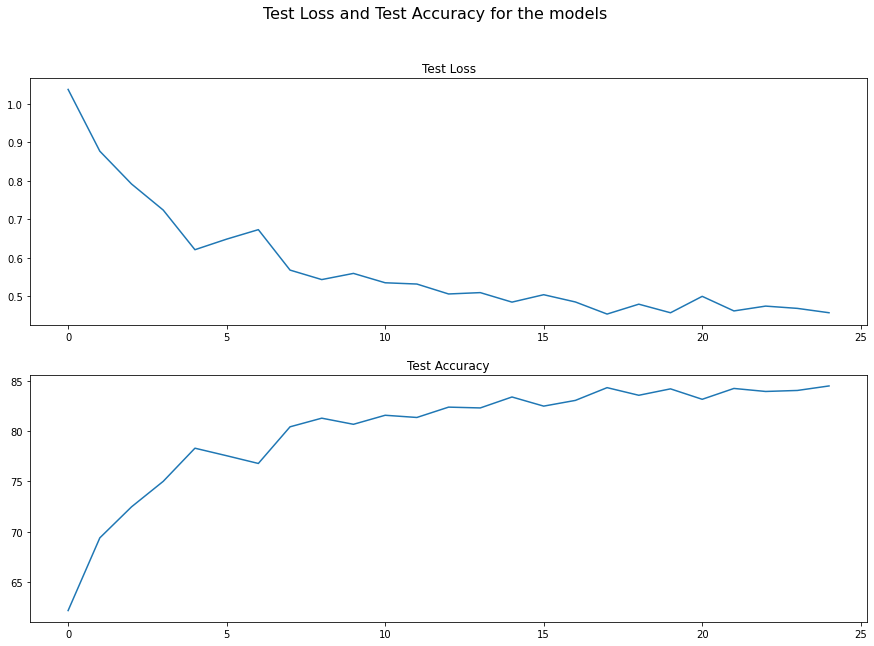

In [7]:
if __name__ == '__main__':
  from tqdm import tqdm
  if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')
  
  main(classes)